# **Chap 5：感知机和支持向量机**

In [1]:
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.datasets import make_classification, make_circles, make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

本章所介绍的两种方法可以用于解决二分类问题，并且它们都属于**线性**分类模型
* 感知机在特征空间中找到**分类超平面**，将正负两类样本通过分离超平面分隔开，属于**判别模型**
* 支持向量机（SVM）可以认为是感知机的延申和扩展，它的学习过程也是寻找分离超平面的过程，但SVM对超平面的要求更严格，需要满足**间隔最大化**的要求

此外，SVM方法通过引入**核函数**的概念还可以推广到**非线性分类**的场合，SVM同时还被扩展到解决**回归问题**，即**支持向量回归器**

## **1 感知机 Perceptron**

简单来说，感知机的学习过程需要在**线性可分**假设下，求出能够将训练数据进行线性划分的分离超平面，它的步骤简单清晰，主要包含两个步骤：
* 构建基于误分类的损失函数
* 使用梯度下降方法极小化损失函数，得到模型参数

感知机的模型参数就是分离超平面相关的参数（或者说平面系数）

感知机模型的求解分为**原始形式**和**对偶形式**两种，对偶形式在部分场景下能加速算法求解  
虽然现在感知机已经退出机器学习主流的舞台，但它是**神经网络**和**SVM**的基础，它对问题的建模思想非常值得深入学习

### **1.1 感知机模型**

假设特征空间 $X=\mathbb{R}^p$，输出空间为二元离散空间 $Y=\{-1,+1\}$，$(x,y)$ 代表某个实例点，定义从输入空间到输出空间的映射 $f:X\to Y$

$$
f(x)=\text{sign} (wx+b)
$$

$f$ 称为感知机，其中 $w\in\mathbb{R}^p,b\in\mathbb{R}$ 称为感知机模型参数，它们决定了$\mathbb{R}^p$ 空间中的一个超平面 $S$，$\text{sign}$ 是符号函数

感知机中，$w$ 被称为权重（weight）或权重向量，$b$ 称为偏置（bias），$wx$ 表示 $w,x$ 做内积，为简化符号这里没有写作标准的 $w^Tx$ 的向量形式

可以看到，感知机和逻辑回归类似，都是定义在特征空间上的**线性分类模型**，它的假设空间 $\mathcal{F}$ 可以表示为如下函数集合

$$
\mathcal{F} = \{f | f(x)=wx+b, w\in\mathbb{R}^p, b\in\mathbb{R}  \}
$$

从几何上来看，感知机**通过线性方程** $wx+b=0$ 得到特征空间 $\mathbb{R}^p$ 的一个**超平面** $S$，其中，$w$ 是 $S$ 的法向量，$b$ 是超平面 $S$ 的截距

<img src="./source/Chap5/感知机示意图.png" width=500>

上图展示了 $p=2$ 时的分离超平面 $S$ 的示意图，此时 $S$ 是一条直线

$S$ 将整个空间分为两个部分，两侧的样本点将被分别标记为正类和负类，在 $S$ 上的点满足 $wx+b=0$，在任何一侧的点都将有 $wx+b > 0$ 或者 $wx+b < 0$，再经由 $f(x)=\text{sign} (wx+b)\in \{-1,+1\}$ 就可以完成分类决策了

### **1.2 感知机策略**

当给定训练数据集 $T = \{(x_i,y_i)\}_{i=1}^{N}$，其中，$x_i\in\mathbb{R}^p, y\in \{-1,+1\}$，如何确定超平面 $S$ 的参数 $w,b$ 呢？

首先，我们要求数据**线性可分可分**的假设

**(Def) 线性可分性质**：给定数据集 $T = \{(x_i,y_i)\}_{i=1}^{N}$，其中，$x_i\in\mathbb{R}^p, y\in \{-1,+1\}$，如果存在某个超平面 $S$

$$
S : wx+b = 0,\quad w\in\mathbb{R}^p, b\in\mathbb{R}
$$

能够将数据集的正实例和负实例点完全正确地划分到 $S$ 的两侧，即对所有 $y_i = +1$ 的样本点 $i$，$wx_i + b > 0$；对所有 $y_i = -1$ 的样本点 $i$，$wx_i + b < 0$，则称数据集 $T$ 为线性可分数据集，否则，就 $T$ 线性不可分

下面我们假设数据集是**线性可分的**，感知机的目标是得到一个能够将正负类实例完全正确分开的分离超平面 $S$，为了找到 $S$，即求出对应的参数 $w,b$，我们将从**误分类**出发构造损失函数，极小化损失函数得到模型的求解策略

损失函数的自然选择可以是**误分类点的个数**，即：

$$
L(w,b) = \sum_{i=1}^{N} \mathbb{I}(f(x_i)\ne y_i)
$$

这类似于使用**分类错误率**作为损失函数，缺点是**损失函数的解析性质差**，它关于参数 $w,b$ 不是连续可微的，不易于优化

感知机所采用的损失函数是**误分类点到超平面的总距离**，为此，空间中任何一点 $x_0$ 到 $S$ 的距离为：

$$
\frac{1}{\| w \|} |wx_0 + b|
$$

其中，$\|w\|$ 是 $w$ 的 $L_2$ 范数，其次，对于误分类的点 $(x_i,y_i)$，有：

$$
-y_i(wx_i+b) > 0
$$

这是显然的，这意味着 $wx_i + b > 0$ 时，$y_i = -1$，或反之 $wx_i + b < 0$ 时，$y_i = +1$

因此，误分类点 $(x_i,y_i)$ 到超平面 $S$ 的距离表示为：

$$
-\frac{1}{\|w\|} y_i(wx_i + b)
$$

最后，记所有误分类点的集合为 $M$，误分类点的总距离为：

$$
-\frac{1}{\|w\|} \sum_{x_i\in M} y_i(wx_i + b)
$$

感知机的决策不考虑超平面的模长 $\| w \|$，得实际使用中，集合 $M$ 用训练集数据，得到**经验损失函数**：

$$
R_{emp}(L) = L(w,b) = - \sum_{x_i\in M} y_i(wx_i + b)
$$

损失函数 $L(w,b)$ 是非负的，**如果没有误分类点**，那么 $M=\emptyset$，$L(w,b)=0$，且误分类点越少，误分类点距离超平面 $S$ 越近，损失函数值越小

注意到，对于某个特定的样本 $(x_i,y_i)$，误分类时，损失是 $w,b$ 的线性函数，正确分类时损失为 $0$，因此 $L(w,b)$ 是关于参数 $w,b$ 的连续可微函数

模型的策略即极小化**经验损失函数**：

$$
(w^*,b^*) = \mathop{\arg\min}\limits_{w,b} L(w,b)
$$

### **1.3 感知机算法**

求解模型策略最优化问题的方法将使用**梯度下降法**，具体实现上，有两种形式：**原始形式**和**对偶形式**

#### **1.3.1 原始形式**

感知机的学习由关于误分类点的极小化问题驱动，我们可采用**随机梯度下降**（**SGD**）算法求解

初始时刻，任意选取一个超平面，即初始化参数 $w_0,b_0$，然后用梯度下降方法不断更新参数 $w,b$，每次执行梯度下降过程中，不需要**一次性对所有误分类点** $M$ 做计算，而是每次随机挑选一个误分类点 $x_i\in M$，仅对一个点进行梯度下降，对某个特定点 $(x_i,y_i)$，其梯度为：

$$
\nabla_w L(x_i;w,b) = -y_ix_i,\quad \nabla_b L(x_i;w,b) = -y_i
$$

选定某一个学习率 $\eta>0$，则SGD的更新过程为：

$$
w \leftarrow w + \eta\cdot y_ix_i,\quad b\leftarrow b + \eta y_i
$$

不断随机选择 $x_i \in M$，然后迭代计算上式使 $L(w,b)$ 不断减小，直到 $L(w,b) = 0$（线性可分条件下），即得到一个分离超平面 $S=\{w^*,b^*\}$ 

关于这个算法，做以下几点说明：
* 从几何上看，感知机的 SGD 学习过程可以理解为当一个实例点被错误分类，即位于超平面 $S$ 的错误一侧时，SGD 就调整超平面 $W,B$ 的值，使得分离超平面向该误分类点的一侧移动，以减小该误分类点与超平面之间的距离，直到所有点都被正确分类
* SGD 更新过程中，集合 $M$ 会发生改变，直到 $M = \emptyset$
* 感知机得到的 $w^*,b^*$ 不是唯一的，它与初始值、学习率、每次迭代选择的误分类点 $x_i\in M$都有关，只要能正确分离的任何一组超平面参数 $w,b$ 都可能是最终得到的解

上面第三点说明，虽然感知机 SGD 算法的解不唯一，但我们能保证在**线性可分问题下**，算法一定是**收敛的**

**Novikoff定理**：设训练集 $T=\{(x_i,y_i)\}_{i=1}^{N}$ 线性可分，则：  
(1) 存在满足 $\|(w^*,b^*)\| = 1$ 的超平面 $w^* x + b^* = 0$ 将 $T$ 完全正确分开，且存在 $\gamma > 0$ 使得对 $\forall i$，有：
$$
y_i(w^* x_i + b^*) \geq \gamma > 0
$$
(2) 设 $R = \max_{1\leq i\leq N}\|(x_i,1)\|$，感知机 SGD 算法的误分类次数 $k$ 满足：
$$
k\leq \left(  \frac{R}{\gamma}\right)^2
$$

其中，$(w^*,b^*)$ 和 $(x_i,1)$ 是将 $\mathbb{R}^p$ 维的向量和一个实数拼在一起，构造了 $\mathbb{R}^{p+1}$ 维向量

上面的定理，保证了感知机 SGD 算法的收敛性，并保证算法将在有限次迭代内收敛

思考，如果问题**不是线性可分**，使用感知机 SGD 算法求解，会遇到什么问题？

#### **1.3.2 对偶形式**

这里给出对偶形式的解法，为后文SVM的对偶形式做铺垫

对偶形式的基本想法，是将 $w,b$ 表示为实例 $x_i,y_i$ 的线性组合，然后直接求解线性组合的系数得到 $w,b$

具体来讲，在感知机 SGD 算法中，每一步更新 $w,b$ 的公式为：

$$
w \leftarrow w + \eta y_i x_i,\quad b\leftarrow b + \eta y_i
$$

如果我们取初始值 $w_0,b_0$ 为0，则更新结束后，$w,b$ 会有如下表达式：

$$
w = \sum_{i=1}^{N} a_iy_i x_i,\quad b = \sum_{i=1}^{N} a_i y_i
$$

其中，$a_i = n_i\eta\geq 0$，$n_i$ 表示样本 $(x_i,y_i)$ 参与更新的次数

从更新中不难注意到，$n_i$ 越大，样本 $(x_i,y_i)$ 参与更新次数越多，意味着**它距离分离超平面越进**，也就**越难分类正确**，或者说，这样的**实例点对模型学习结果影响最大**

从这里我们能感受到**支撑向量**的感觉，即模型**最终的超平面只和那些靠近超平面的样本有关**，更深入的讨论我们在SVM中进行

将 $w$ 的新表达式代入模型，得到决策函数：

$$
f(x) = \text{sign}\left( \sum_{i=1}^{N} a_iy_ix_i x + b \right)
$$

此时，模型求解的参数变为 $a=(a_1,a_2,\cdots,a_N),b$，求解流程如下：
* (1) 初始化：$a\leftarrow 0, b\leftarrow 0$
* (2) 在训练集中选取误分类点 $(x_j,y_j)$ 使得：
$$
y_j\left( \sum_{i=1}^{N} a_i y_i x_i x_j + b \right) \leq 0
$$
* (3) 进行更新：
$$
a_j \leftarrow a_j + \eta,\quad b \leftarrow b + \eta y_j
$$
* (4) 重复(2),(3)直到没有误分类点

对偶形式中，每一步计算我们都需要用到 $x_i,x_j$ 两点的内积结果 $x_ix_j$，为了**减小运算量**，可以**预先将训练集中两两实例间的内积计算出来**，并以矩阵的形式存储，这个矩阵一般称为 Gram 矩阵：

$$
\boldsymbol{G} = [x_i^Tx_j]_{N\times N}
$$

这样，在模型学习时，只需要**查表**，访问矩阵 $\boldsymbol{G}$ 对应位置的元素即可，无需每次重新计算内积

### **1.4 感知机实现**

这里仅实现感知机的原始算法

In [2]:
def PerceptronSGD(X : np.ndarray, y : np.ndarray, eta : float=1):
    """
    Parameters
    ----------
    X : np.ndarray
        训练集的输入特征
    y : np.ndarray
        训练集标签，取值`{-1,+1}`
    eta : float, default = `0.5`
        学习率
    
    Return
    ----------
    (w,b) : np.ndarray
        返回分离超平面的参数
    """
    
    # 特征维度
    p = X.shape[1]
    # 初始化
    w, b = np.zeros(p), 0
    # 确定误分类集合
    M = np.where(y * (X @ w + b) <= 0)[0]
    
    while len(M) > 0: # 循环直到没有误分类点
        # 随机选择一个实例进行梯度下降
        i = np.random.choice(M)
        w = w + eta*y[i]*X[i]
        b = b + eta*y[i]
        
        # 更新误分类集合
        M = np.where(y * (X @ w + b) <= 0)[0]
    
    return w, b

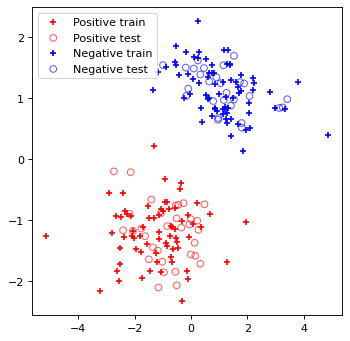

In [3]:
# 创建数据集
X, y = make_classification(
    n_samples=200,n_features=2,n_redundant=0,n_clusters_per_class=1,
    random_state=4321,class_sep=1.1,flip_y=0)
# 将 y 从 {0,1} 变换到 {-1,1}
y = y*2 - 1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=2022)
fig,ax = plt.subplots(1,1,figsize=(5,5),dpi=80)
for label in [1,-1]:
    color = "red" if label == 1 else "blue"
    types = "Positive" if label == 1 else "Negative"
    # 绘制训练集
    ax.scatter(X_train[y_train==label,0],X_train[y_train==label,1],
                c=color,marker="+",label="%s train"%(types))
    # 绘制测试集
    ax.scatter(X_test[y_test==label,0],X_test[y_test==label,1],
                c='none',marker="o",edgecolors=color,label="%s test"%(types),alpha=0.6)
ax.legend()

In [4]:
# 重复三次
for i in range(3):
    # 求解分离超平面
    w, b = PerceptronSGD(X=X_train,y=y_train)
    # 利用 w[0]*x1 + w[1]*x2 + b = 0，求解分离超平面的两个坐标
    x1, x2 = -4, 4
    y1, y2 = -(b + w[0]*x1) / w[1], -(b + w[0]*x2) / w[1]
    # 绘制超平面
    ax.plot([x1,x2],[y1,y2],c="green",ls="--",label="Hyperplane %d"%(i+1))
    ax.legend(loc="upper left")

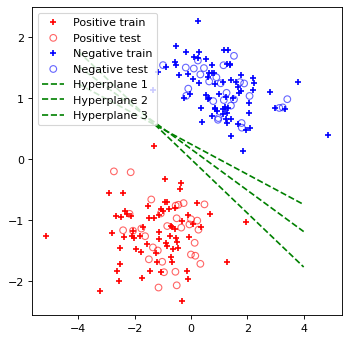

In [5]:
fig

----

## **2 支持向量机 SVM**

支持向量机（Support Vector Machines) **SVM** 是一种二分类模型，它的基本模型是定义在特征空间上的**间隔最大的线性分类器**

间隔最大化使SVM有别于前面介绍的感知机；SVM还可以引入**核函数**的概念，使其从线性分类器变为**非线性分类器**

下面介绍的内容，将按从简到繁的顺序，分别引出三个模型：
* **线性可分SVM**
    * 当数据线性可分时，通过**硬间隔最大化**得到线性可分SVM
* **线性SVM**
    * 实际场景下，几乎没有线性可分数据，因此减弱条件得到**近似线性可分**问题，此时通过**软间隔最大化**得到线性SVM
* **引入核函数的非线性SVM**
    * 当数据分布呈现很强的非线性特征时，在线性SVM基础上引入**核函数**，通过**软间隔最大化**得到非线性SVM

注意上述简单模型是复杂模型的基础，也是复杂模型的特殊情况

### **2.1 线性可分支持向量机**

首先明确，在讨论SVM模型时，我们需要将输入空间 $\mathcal{I}$ 和 特征空间 $\mathcal{X}$ 分开

一般来说，输入空间 $\mathcal{I}$ 为欧式空间（连续实数变量）或者离散集合（性别、城市等离散变量），特征空间 $\mathcal{X}$ 为欧式空间或者Hilbert空间

对于线性可分SVM和线性SVM，我们假设两个空间 $\mathcal{I},\mathcal{X}$ 中的元素一一对应，直接将输入空间 $\mathcal{I}$ 的输入 $o_i$ 映射为特征空间 $\mathcal{X}$ 中的特征向量 $x_i$，而非线性SVM将使用一个非线性映射 $f_K:\mathcal{I}\to\mathcal{X}$，将输入 $o_i$ 变换为特征向量 $x_i$，其中，$K$ 表示非线性SVM所选择的核函数. 因此，**输入都由输入空间转换到特征空间**，**SVM的学习在特征空间进行**

与感知机类似，假设我们有**特征空间上**的**线性可分**数据集：
$$
T=\{(x_i,y_i)\}_{i=1}^{N},\quad x_i\in\mathcal{X}=\mathbb{R}^{n},\quad y_i\in\mathcal{Y}=\{-1,+1\}
$$

回顾**分离超平面** $S:wx+b=0$，每个超平面 $S$ 由参数 $(w,b)$ 确定，其中，$w\in\mathbb{R}^p$ 是法向量，$b\in\mathbb{R}$ 代表截距，法向量指向的一侧为**正类样本**，另一侧为**负类样本**. 当训练数据线性可分时，存在无穷多个分离超平面 $S$ 将两类数据分隔开，感知机使用**误分类最小**的策略，求得 $S$，此时解有无穷多个，线性可分SVM利用间隔最大化求解 $S$，此时的**解是唯一的**

那么自然的问题是，**如何定义间隔**？

#### **2.1.1 函数间隔和几何间隔**

一般来说，一个点距离平面 $S$ 的远近可以表示分类预测的**确信度**，如图所示，点 $A$ 相较点 $C$，我们有更大的把握认为它分类正确，因为它远离平面 $S$，不会与另一类样本混淆

<img src="./source/Chap5/间隔示意图.png" width=400>

在超平面 $S:wx+b=0$ 确定时，对于某个样本 $x_0$，$|wx_0+b|$ 能够相对地表示点 $x_0$ 距离超平面 $S$ 的远近，而 $\text{sign}(wx_0+b)$ 与标签 $y_i$ 符号是否一致能够表示分类是否正确，那么自然地，我们可以用 $y(wx+b)$ 同时表示分类的正确性与确定度，这就是**函数间隔**

**(Def) 函数间隔**：对于给定的训练数据集 $T$和超平面 $(w,b)$，定义每个样本点 $(x_i,y_i)$ 的函数间隔为：
$$
\hat{\gamma}_i = y_i(wx_i+b)
$$
再定义超平面 $(w,b)$ 关于训练集 $T$ 的函数间隔为所有样本中函数间隔的最小值：
$$
\hat{\gamma} = \min_{i=1,\cdots,N}{\hat{\gamma}_i}
$$

虽然函数间隔能够刻画分类正确性与确信度，但很快注意到，在选择参数 $(w,b)$ 时，仅依靠函数间隔还不够，因为只要成比例的同时改变 $w,b$，则**超平面** $wx+b=0$ **不会发生改变**，但**函数间隔却按照相同的比例改变了**，这就给通过函数间隔寻找最优超平面带来困扰

上述事实启发我们，需要对超平面的法向量 $w$ 增加某些约束，例如规范化 $\|w\| = 1$，**使得间隔在超平面确定时也是确定的**，这时函数间隔就成为i**几何间隔**

如图所示，线段 $AB$ 给出了点 $A$ （表示样本点 $x_i$）超平面 $(w,b)$ 的距离，距离 $\gamma_i$ 满足：
$$
\gamma_i = \left(\frac{w}{\|w\|}x_i+\frac{b}{\|w\|}\right)
$$

<img src="./source/Chap5/几何间隔示意图.png" width=500>

其中，$\|w\|$ 表示 $w$ 的 $\ell_2$ 范数，如果点 $A$ 在超平面另一侧，此时 $y_i=-1$，点到超平面的距离为：
$$
\gamma_i = -\left(\frac{w}{\|w\|}x_i+\frac{b}{\|w\|}\right)
$$

不难发现，当样本点 $(x_i,y_i)$ 被正确分类时，距离 $\gamma_i$ 可以表示为：
$$
\gamma_i = y_i\left(\frac{w}{\|w\|}x_i+\frac{b}{\|w\|}\right)
$$

由此，可以导出**几何间隔**的定义

**(Def) 几何间隔**：对于给定的训练数据集 $T$和超平面 $(w,b)$，定义每个样本点 $(x_i,y_i)$ 的几何间隔为：
$$
\gamma_i = y_i\left(\frac{w}{\|w\|}x_i+\frac{b}{\|w\|}\right)
$$
再定义超平面 $(w,b)$ 关于训练集 $T$ 的几何间隔为所有样本中几何间隔的最小值：
$$
\gamma = \min_{i=1,\cdots,N}{\gamma_i}
$$

关于几何间隔，注意以下两点：
* 几何间隔同样代表了分类正确性和确信度，且此时**确信度在超平面确定后是唯一确定的**
* 几何间隔是**带符号的距离**，当分类正确时，该距离就是点到超平面的距离，否则是**距离的相反数**

不难发现，函数间隔和几何间隔有如下关系：
$$
\gamma_i = \frac{\hat{\gamma}_i}{\|w\|},\quad \gamma = \frac{\hat{\gamma}}{\|w\|}
$$

因此，如果限制 $\|w\| = 1$，那么函数间隔和几何间隔等价

间隔的定义清楚了，接下来，我们便可以讨论间隔最大化问题了

#### **2.1.2 间隔最大化**

SVM学习的基本思想是求解能够正确划分训练数据且**几何间隔**最大的分离超平面，下面介绍的间隔最大化又称为**硬间隔最大化**

间隔最大化的**直观解释**是，对训练数据找到几何间隔最大的超平面，就意味着**以充分大的确信度将数据进行了划分**，也就是说，不仅将正负样本分离开，而且**对最难区分的实例点（距离超平面最近的点）**，也有足够大的确定度将它们分开，这样的超平面应该**对未知的新实例**（测试集）有很好的分类预测能力

我们依然按照**模型**、**策略**和**算法**三步走来分析线性可分SVM

**(1) 模型**

线性可分SVM采用与感知机相同的模型，即：

$$
f(x) = \text{sign}(wx+b)
$$

其中，$(w,b)$ 是模型的参数

**(2) 策略**

考虑几何间隔最大化，构建模型的学习策略：

$$
\begin{array}{cl}
\max_{w,b} & \gamma \\
\text{s.t.} & \displaystyle{ y_i\left(\frac{w}{\|w\|} x_i + \frac{b}{\|w\|}\right)\geq \gamma,\quad i=1,\cdots,N } \\
\end{array}
$$

约束表示每个样本点关于超平面的几何间隔至少是 $\gamma$，然后我们极大化 $\gamma$

考虑几何间隔和函数间隔的关系，上述优化问题可以改写为：

$$
\begin{array}{cl}
\max_{w,b} & \displaystyle{ \frac{\hat{\gamma}}{\|w\|} } \\
\text{s.t.} & \displaystyle{ y_i(wx_i+b)\geq \hat{\gamma},\quad i=1,\cdots,N } \\
\end{array}
$$

再注意到**函数间隔** $\hat{\gamma}$ **的取值并不影响最优化问题的解**，例如将 $w,b$ 同时放大 $\lambda$ 倍得到 $\lambda w,\lambda b$，则函数间隔变为 $\lambda\hat{\gamma}$，代入上式，会发现**优化目标的值没有改变**，同时**不等式约束也不会受到影响**，这说明它产生了一个等价的最优化问题

这样不妨取 $\hat{\gamma} = 1$，将 $\hat{\gamma} = 1$ 代入上式，并注意到最大化 $\|w\|^{-1}$ 与最小化 $\|w\|^2/2$ 等价，得到：

$$
\begin{array}{cl}
\min_{w,b} & \displaystyle{ \frac{1}{2}\|w\|^2 } \\
\text{s.t.} & \displaystyle{ y_i(wx_i+b) - 1\geq 0,\quad i=1,\cdots,N } \\
\end{array}
$$

这是一个关于 $w,b$ 的**凸二次规划问题**

**(Def) 凸二次规划**：考虑最优化问题：
$$
\begin{array}{cl}
\min_{w} & f(w) \\
\text{s.t.} & g_i(w) \leq 0,\quad i=1,\cdots,k\\
& h_i(w) = 0,\quad i=1,\cdots,l
\end{array}
$$
如果 $f(w),g_i(w)$ 都是 $w\in\mathbb{R}^n$ 上的连续可微凸函数，约束 $h_i(w)$ 是 $\mathbb{R}^n$ 上的线性函数，则上述问题称为**凸优化问题**  
当目标 $f(w)$ 是二次函数，且约束 $g_i(w)$ 也是线性函数时，凸优化问题称为**凸二次规划问题**

线性可分SVM的策略即为求解上面的凸二次规划问题，得到解：
$$
w^*,b^* = \mathop{\arg\min}\limits_{w,b} \frac{1}{2}\|w\|^2,\quad \text{s.t.} \quad y_i(wx_i+b) - 1\geq 0,\quad i=1,\cdots,N 
$$

需要指出，按照上述策略求得的间隔最大化超平面一定**存在且唯一**

再进一步讨论SVM的算法之前，我们先讨论**支持向量**、**间隔边界**这两个概念

**(Def) 支持向量**：在线性可分的情况下，我们将训练数据集中样本点中**与分离超平面距离最近的样本点**称为**支持向量**（Support Vector），从优化目标式子定义，支持向量是使得约束成立的点：
$$
y_i(wx_i + b) - 1 = 0
$$

不难发现，对于 $y_i=+1$ 的正例样本，支持向量在超平面：
$$
H_1 : wx + b = 1
$$

对于 $y_i=-1$ 的负例样本，支持向量在超平面：
$$
H_2 : wx + b = -1
$$

并且，$H_1,H_2$ 是平行的，**不会有任何样本点会落在它们中间**，$H_1,H_2$ 之间形成了一个条带区域，分离超平面 $S$ 与它们平行，且位于条带的中心

$H_1,H_2$ 之间条带的宽度 $m$ 称为**间隔**（margin），间隔大小依赖于分离超平面法向量：
$$
m = \frac{2}{\|w\|}
$$

因此，$H_1,H_2$ 被称为**间隔边界**

支持向量、间隔边界、分离超平面和间隔示意图如下所示：

<img src="./source/Chap5/间隔边界和支持向量.png" width=500>

进一步分析会发现，**决定分离超平面时只有支持向量起作用**，而其他点并没有用，移动支持向量将改变所求的解，但如果在间隔边界外移动其他实例点，甚至去掉这些点，SVM的解是不会改变的，由于支持向量在确定分离超平面时的这种决定性作用，所以将模型称为**支持向量机**，一般情况下，支持向量的个数很少，所以SVM由**很少的但重要的**训练样本来确定

接下来，我们讨论模型的求解算法

#### **2.1.3 SVM学习的对偶算法**

为了求解策略部分提出的优化问题，我们将应用**Lagrange对偶性**，通过求解对偶问题得到原问题的最优解，使用对偶方法求解有两个**优点**：
* 相比原始问题，对偶问题更容易求解
* 对偶问题便于引入核函数，方便我们推广到非线性分类问题

我们回顾需要解决的最优化问题：

$$
\begin{array}{cl}
\min_{w,b} & \displaystyle{ \frac{1}{2}\|w\|^2 } \\
\text{s.t.} & \displaystyle{ y_i(wx_i+b) - 1\geq 0,\quad i=1,\cdots,N } \\
\end{array}
$$

**引入Lagrange乘子** $a_i\geq 0,i=1,\cdots,N$，得到**Lagrange函数**：

$$
L(w,b,a) = \frac{1}{2}\|w\|^2 - \sum_{i=1}^{N}a_i\left[y_i(wx_i+b)-1\right] = \frac{1}{2}\|w\|^2 - \sum_{i=1}^{N}a_iy_i(wx_i+b) + \sum_{i=1}^{N}a_i
$$

其中，$a=(a_1,a_2,\cdots,a_N)$ 是Lagrange乘子向量，则原问题可以写为：

$$
\min_{w,b} \frac{1}{2}\|w\|^2 \Leftrightarrow \min_{w,b}\max_{a} L(w,b,a)
$$

根据Lagrange对偶性，原始问题的对偶问题是下面的**极大极小问题**：

$$
\max_{a}\min_{w,b} L(w,b,a)
$$

因此，为了得到原问题的解，需要先求 $L(w,b,a)$ 关于 $(w,b)$ 的极小，再对 $a$ 求极大

**(1) 求极小问题**：$$\min_{w,b}L(w,b,a)$$

直接求偏导，并令偏导数等于0，得到：
$$
\begin{array}{l}
\nabla_w L(w,b,a) = w - \sum_{i=1}^{N}a_iy_ix_i = 0 \\
\nabla_b L(w,b,a) = -\sum_{i=1}^{N}a_iy_i = 0
\end{array}
$$

上式解得：
$$
w=\sum_{i=1}^{N}a_iy_ix_i,\quad \sum_{i=1}^{N}a_iy_i = 0
$$

将上式代入Lagrange函数，得到：

$$
\begin{array}{rcl}
L(w,b,a) & = & \displaystyle{ \frac{1}{2}\|w\|^2 - \sum_{i=1}^{N}a_iy_i(wx_i+b) + \sum_{i=1}^{N}a_i } \\
& = & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle - \sum_{i=1}^{N}a_iy_i\left(\left( \sum_{j=1}^{N}a_iy_ix_j \right)x_i+b\right) + \sum_{i=1}^{N}a_i } \\
& = & \displaystyle{ -\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle + \sum_{i=1}^{N}a_i } \\
\end{array}
$$

综上，得到：

$$\min_{w,b}L(w,b,a) = -\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle + \sum_{i=1}^{N}a_i$$

**(2) 求极大问题**：$$\max_{a}\min_{w,b}L(w,b,a)$$

接下来，需要解决关于 $a$ 的优化问题：

$$
\begin{array}{cl}
\max_{a} & \displaystyle{ -\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle + \sum_{i=1}^{N}a_i } \\
\text{s.t.} & \displaystyle{\sum_{i=1}^{N}a_iy_i = 0} \\
& a_i\geq 0,\quad i=1,2,\cdots,N
\end{array}
$$

或者写作如下的极小化问题：

$$
\begin{array}{cl}
\min_{a} & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle - \sum_{i=1}^{N}a_i } \\
\text{s.t.} & \displaystyle{\sum_{i=1}^{N}a_iy_i = 0} \\
& a_i\geq 0,\quad i=1,2,\cdots,N
\end{array}
$$

如何说明**求解对偶问题就能获得原问题的最优解**呢？我们需要引入有关Lagrange对偶问题的几个定理和**KKT条件**

**(Thm) 原问题和对偶问题的关系**：假设原始问题和对偶问题都有最优解，则：
$$
d^* = \max_{a}\min_{w,b}L(w,b,a) \leq \min_{w,b}\max_{a} L(w,b,a) = p^*
$$

上式证明是显然的，只需要注意到对任意的 $w_0,b_0,a_0$ 有：

$$
\min_{w,b}L(w,b,a_0)\leq L(w_0,b_0,a_0) \leq \max_{a} L(w_0,b_0,a)
$$

**(Thm) 等价性**：考虑凸优化问题：
$$
\begin{array}{cl}
\min_{w} & f(w) \\
\text{s.t.} & g_i(w) \leq 0,\quad i=1,\cdots,k\\
& h_i(w) = 0,\quad i=1,\cdots,l
\end{array}
$$
问题的Lagrange函数为：
$$
L(w,a,b) = f(w) + \sum_{i=1}^{k}a_ig_i(w) + \sum_{j=1}^{l}b_jh_j(w)
$$
在考虑上述原问题及其对偶问题时，如果目标函数和不等式约束都是凸函数、等式约束是线性变换，并假设不等式约束严格可行，即存在 $s$ 对所有 $i$ 成立 $g_i(w) < 0$，则存在 $w^*,a^*,b^*$，使得 $w^*$ 是原问题的解，$a^*,b^*$ 是对偶问题的解，并且：
$$
p^* = d^* = L(w^*,a^*,b^*)
$$

**(Thm) KKT条件**：延续**等价性**定理中的假设，则 $w^*$ 和 $a^*,b^*$ 分别是原问题和对偶问题的解的充分必要条件是 $w^*,a^*,b^*$ 满足如下**KKT**条件：
* 平稳性：$\nabla_w L(w^*,a^*,b^*) = 0$
* 互补松弛：$a_i^*\cdot g_i(w^*) = 0,\quad i=1,\cdots,k$
* 原问题约束1：$g_i(w^*)\leq 0, \quad i=1,\cdots,k$
* 原问题约束2：$h_i(w^*) = 0,\quad i=1,\cdots,l$
* 对偶问题约束：$a_i^* \geq 0,\quad i=1,\cdots,k$

回到SVM的对偶算法，注意到，原问题满足**等价性定理**中的条件，因此存在 $w^8,b^*,a^*$，使得 $w^*,b^*$ 是原问题的解，$a^*$ 是对偶问题的解，这意味着通过求解关于 $a$ 的对偶最优化问题来获得原问题的解是可行的

下面，根据**KKT**定理，我们写出SVM问题的KKT条件：

$$
\begin{array}{rl}
\text{平稳性1} & \displaystyle{ \nabla_w L(w^*,b^*,a^*) = w^* - \sum_{i=1}^{N}a_i^*y_ix_i = 0 } \\
\text{平稳性2} & \displaystyle{ \nabla_b L(w^*,b^*,a^*) = - \sum_{i=1}^{N}a_i^*y_i = 0 } \\
\text{互补松弛} & \displaystyle{ a_i^*(y_i(w^*x_i + b^*) - 1) = 0,\quad i=1,\cdots,N } \\
\text{原问题约束} & y_i(w^*x_i + b^*) - 1 \geq 0,\quad i=1,\cdots,N \\
\text{对偶问题约束} & a_i^*\geq 0,\quad i=1,\cdots,N
\end{array}
$$

设 $a^*$ 是我们通过对偶问题获得的最优解，由**平稳性1**得到：
$$
w^* = \sum_{i=1}^{N}a_i^*y_ix_i
$$

因为法向量 $w^*$ 不为**零向量**（若否，用反证法，假设 $a^* = 0, w^* = 0$，可验证 $w^* = 0$ 不是原问题的解），因此至少有一个 $a_j^* > 0$

那么由**互补松弛**，对此 $j$，一定有：
$$
y_j(w^*x_j + b^*) - 1 = 0
$$

上式乘以 $y_j$ 并利用 $y_j^2 = 1$，代入 $w^*$ 得到：

$$
b^* = y_j - \sum_{i=1}^{N}a_i^*y_i\langle x_i,x_j \rangle
$$

这样，就通过对偶问题的解 $a^*$ 以及KKT条件，得到了原问题的解 $w^*,b^*$

至此，我们将线性可分SVM的对偶算法总结如下：

**线性可分SVM的对偶算法**：给定线性可分数据集 $T=\{(x_i,y_i)\}_{i=1}^{N}$，其中 $x_i\in\mathcal{X}=\mathbb{R}^p$，$y_i\in\mathcal{Y}=\{-1,+1\}$
* 第一步，构造并求解约束最优化问题，得到 $a^*$：
$$
\begin{array}{cl}
\min_{a} & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle - \sum_{i=1}^{N}a_i } \\
\text{s.t.} & \displaystyle{\sum_{i=1}^{N}a_iy_i = 0} \\
& a_i\geq 0,\quad i=1,2,\cdots,N
\end{array}
$$
* 第二步，选择一个 $a^*$ 的正分量 $a_j^* > 0$，计算分离超平面参数
$$
w^* = \sum_{i=1}^{N}a_i^*y_ix_i,\quad b^* = y_j - \sum_{i=1}^{N}a_i^*y_i\langle x_i, x_j\rangle
$$
* 第三步，得到分离超平面 $w^*x + b^* = 0$，SVM的决策函数为：
$$
f(x) = \text{sign}(w^*x + b^*)
$$

注意到，$w^8, b^*$ 的计算只与那些 $a_i^* > 0$ 的实例有关，因此，我们定义在**对偶算法**中，训练数据中使得 $a_i^* > 0$ 的样本点构成**支持向量**

这一点其实**与原问题对支持向量的定义不矛盾**，注意到**互补松弛**条件：
$$
a_i^*(y_i(w^*x_i + b^*) - 1) = 0, i = 1,\cdots,N
$$

在对偶问题中 $a_i^* > 0$ 的点，必须要满足：
$$
y_i(w^*x_i + b^*) - 1 = 0
$$

而这正是**原问题**中对**支持向量实例点的定义**，对偶问题的支持向量示意图如下所示

<img src="./source/Chap5/对偶算法的支持向量.png" width=400>

### **2.2 线性支持向量机**

#### **2.2.1 原始问题的定义**

当我们减弱线性可分的条件后，上面讨论的算法将不再能求解SVM模型，因为此时，约束条件：
$$
y_i(wx_i + b) \geq 1
$$
不能对所有的样本点都满足

因此，我们需要修改**硬间隔最大化**，使其成为**软间隔最大化**，以解决线性不可分问题

线性不可分问题的本质是，训练集中存在一些**异常点**（**outlier**），将这些异常点去除后，**剩下的大部分点组成的问题依然是线性可分的**

这启发我们，对于这些异常点，它们无法满足函数间隔大于等于1的约束条件，那么我们可以适当地对每个样点 $(x_i,y_i)$ **放宽条件**，引入**松弛变量** $\xi_i \geq 0$，使得：
$$
y_i(wx_i + b) \geq 1 - \xi_i
$$

当然，**放水**也不能太严重，松弛变量的引入需要付出代价，因此，我们在目标函数中引入松弛变量的代价：

$$
\min_{w,\xi} \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{N}\xi_i
$$

其中，$C > 0$ 称为惩罚系数，一般由问题决定. $C$ 增大时，对误分类的惩罚就增大，$C$ 减小时，模型对误分类的惩罚就减小，我们可以从极端情况来理解：
* 当 $C\to\infty$ 时，所有的 $\xi_i\to 0$，即意味着对每个样本，都必须满足约束 $y_i(wx_i+b)\geq 1$，即没有误分类样本
* 当 $C\to 0$ 时，$\xi_i$ 不会影响到目标函数，那么对任何参数 $(w,b)$，任何样本都能找到一个 $\xi_i$ 使得 $y_i(wx_i+b)\geq 1-\xi_i$，此时极小化目标函数会得到 $w=0$，模型失去分类能力，正所谓模型对误分类的惩罚很小

最小化新的目标有两个含义，使得 $\frac{1}{2}\|w\|^2$尽量小即**间隔尽可能大**，同时使得在 $C$ 水平下，误分类点的个数尽可能小

基于上面的思想，我们就可以**类比线性可分SVM**提出下面的**线性SVM**优化问题，也称为**软间隔最大化**：

线性不可分的线性SVM学习问题解决下面的**软间隔最大化**凸二次规划问题（原始形式）：

$$
\begin{array}{cl}
\min_{w,\xi} & \displaystyle{ \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{N}\xi_i } \\
\text{s.t.} & \displaystyle{ y_i(wx_i + b) \geq 1 - \xi_i,\quad i=1,\cdots,N } \\
& \xi_i\geq 0,\quad i=1,2,\cdots,N
\end{array}
$$

需要做出说明，上述最优化问题的解 $(w,b,\xi)$ 是存在的，且 $w$ 的解唯一，但 $b$ 的解不唯一，而是存在一个解的区间，具体证明细节不做讨论

#### **2.2.2 对偶形式**

引入Lagrange乘子 $a_i\geq 0,\mu_i\geq 0$，构造Lagrange函数：

$$
L(w,b,\xi,a,\mu) = \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{N}\xi_i - \sum_{i=1}^{N}a_i\left[ y_i(wx_i + b) - 1 + \xi_i \right] - \sum_{i=1}^{N}\mu_i\xi_i
$$

对偶问题为极大极小问题：

$$
\max_{a,\mu}\min_{w,b,\xi} L(w,b,\xi,a,\mu)
$$

先求极小问题，同样利用偏导数：

$$
\begin{array}{l}
\nabla_w L(w,b,\xi,a,\mu) = w - \sum_{i=1}^{N}a_iy_ix_i = 0 \\
\nabla_b L(w,b,\xi,a,\mu) = -\sum_{i=1}^{N}a_iy_i = 0 \\
\nabla_\xi L(w,b,\xi,a,\mu) = C - a_i - \mu_i = 0
\end{array}
$$

得到：
$$
w = \sum_{i=1}^{N}a_iy_ix_i,\quad \sum_{i=1}^{N}a_iy_i = 0,\quad C-a_i - \mu_i = 0,\quad i=1,\cdots,N
$$

将这些条件代入 $\min_{w,b,\xi}L(w,b,\xi,a,\mu)$，得到关于 $a$ 的对偶问题：

$$
\begin{array}{cl}
\min_{a} & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle - \sum_{i=1}^{N}a_i } \\
\text{s.t.} & \displaystyle{\sum_{i=1}^{N}a_iy_i = 0} \\
& C-a_i-\mu_i = 0,\quad i=1,\cdots,N \\
& a_i\geq 0,\quad i=1,\cdots,N \\
& \mu_i \geq 0,\quad i=1,\cdots,N
\end{array}
$$

最后三个约束条件，可以合并为 $0\leq 0\leq C$，问题可以写为更简洁的形式：

$$
\begin{array}{cl}
\min_{a} & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle - \sum_{i=1}^{N}a_i } \\
\text{s.t.} & \displaystyle{\sum_{i=1}^{N}a_iy_i = 0} \\
& 0\leq a_i\leq C,\quad i=1,\cdots,N \\
\end{array}
$$

相比**线性可分SVM**的对偶问题，仅增加了关于 $a_i$ 上界的约束

现在，假设我们求得了对偶问题的解 $a^*$，根据对偶理论，原凸二次规划问题满足对等价性定理，则解满足KKT条件：

$$
\begin{array}{rl}
\text{平稳性1} & \displaystyle{ \nabla_w L(w^*,b^*,\xi^*,a^*,\mu^*) = w^* - \sum_{i=1}^{N}a_i^*y_ix_i = 0 } \\
\text{平稳性2} & \displaystyle{ \nabla_b L(w^*,b^*,\xi^*,a^*,\mu^*) = - \sum_{i=1}^{N}a_i^*y_i = 0 } \\
\text{平稳性3} & \displaystyle{ \nabla_\xi L(w^*,b^*,\xi^*,a^*,\mu^*) = C - a_i^* - \mu_i^* = 0 } \\
\text{互补松弛1} & \displaystyle{ a_i^*(y_i(w^*x_i + b^*) - 1 + \xi_i^*) = 0,\quad i=1,\cdots,N } \\
\text{互补松弛2} & \displaystyle{ \mu_i^*\xi_i^*,\quad i=1,\cdots,N } \\
\text{原问题约束1} & y_i(w^*x_i + b^*) - 1 + \xi_i^* \geq 0,\quad i=1,\cdots,N \\
\text{原问题约束2} & \xi_i^* \geq 0,\quad i=1,\cdots,N \\
\text{对偶问题约束1} & a_i^*\geq 0,\quad i=1,\cdots,N \\
\text{对偶问题约束2} & \mu_i^*\geq 0,\quad i=1,\cdots,N
\end{array}
$$

根据**平稳性1**，得到分离超平面法向量：
$$
w^* = \sum_{i=1}^{N}a_i^*y_ix_i
$$

如果存在 $a_j^*$ 使得 $0 < a_j^* < C$，则根据**平稳性3**，**互补松弛1**和**互补松弛2**，必定有：
$$
y_j(w^*x_j + b^*) - 1 = 0
$$

上式乘以 $y_j$，代入 $w^*$，得到 $b^*$ 为：
$$
b^* = y_j - \sum_{i=1}^{N}a_i^*y_i\langle x_i,x_j\rangle
$$

我们把**软间隔最大化**算法总结如下：

**线性SVM的对偶算法**：给定数据集 $T=\{(x_i,y_i)\}_{i=1}^{N}$，其中 $x_i\in\mathcal{X}=\mathbb{R}^p$，$y_i\in\mathcal{Y}=\{-1,+1\}$，给定惩罚系数 $C > 0$
* 第一步，构造并求解约束最优化问题，得到 $a^*$：
$$
\begin{array}{cl}
\min_{a} & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i,x_j\rangle - \sum_{i=1}^{N}a_i } \\
\text{s.t.} & \displaystyle{\sum_{i=1}^{N}a_iy_i = 0} \\
& 0\leq a_i\leq C,\quad i=1,2,\cdots,N
\end{array}
$$
* 第二步，选择一个 $a^*$ 的正分量 $0 < a_j^* < C$，计算分离超平面参数
$$
w^* = \sum_{i=1}^{N}a_i^*y_ix_i,\quad b^* = y_j - \sum_{i=1}^{N}a_i^*y_i\langle x_i, x_j\rangle
$$
* 第三步，得到分离超平面 $w^*x + b^* = 0$，SVM的决策函数为：
$$
f(x) = \text{sign}(w^*x + b^*)
$$

最后，我们来讨论线性SVM的支持向量，我们依然定义使得 $a_i^* > 0$ 的实例点组成支持向量，注意**互补松弛**条件，此时这些点满足：
$$
y_i(w^*x_i + b^*) - 1 + \xi_i^* = 0
$$

单独拿出KKT条件中的三个，注意：
$$
\begin{array}{rl}
\text{平稳性3} & \displaystyle{ \nabla_\xi L(w^*,b^*,\xi^*,a^*,\mu^*) = C - a_i^* - \mu_i^* = 0 } \\
\text{互补松弛1} & \displaystyle{ a_i^*(y_i(w^*x_i + b^*) - 1 + \xi_i^*) = 0,\quad i=1,\cdots,N } \\
\text{互补松弛2} & \displaystyle{ \mu_i^*\xi_i^*,\quad i=1,\cdots,N } \\
\end{array}
$$

因此，有以下几种情况：
* 如果 $a_i^* < C$，则 $\mu_i^* > 0$。从而 $\xi_i^* = 0$
    * 这说明为了正确分类该实例，模型没有付出任何额外误分类代价，这些点刚好落在**间隔边界**上，如下图 $A,B,C$
* 如果 $a_i^* = C$，则 $\mu_i^* = 0$，从而 $\xi_i^* > 0$，又分为三种情况：
    * 如果 $0 < \xi_i^* < 1$，则 $y_i(w^*x_i + b^*) > 0$，该实例被分类正确，但落在了**分离超平面和间隔边界之间**，如下图 $D,E$
    * 如果 $\xi_i^8 = 1$，则 $y_i(w^*x_i + b^*) = 0$，该实例正好**落在分离超平面上**，如下图 $F$
    * 如果 $\xi_i^8 > 1$，则 $y_i(w^*x_i + b^*) < 0$，该实例被分类错误，它落在**分离超平面另一侧**，如下图 $G,H,I$

<img src="./source/Chap5/软间隔支持向量.png" width=600>

#### **2.2.3 合页损失函数**

线性SVM的学习还有另一种解释，即最小化如下的目标函数：

$$
\ell(w,b) = \sum_{i=1}^{N}[1 - y_i(wx_i + b)]_{+} + \lambda \|w\|^2
$$

式子中的第一项表示经验风险函数：
$$
L(y(wx+b)) = [1-y(wx+b)]_+,\quad [x]_+ = x\cdot \mathbb{I}(x > 0)
$$

上式表明，当样本的函数间隔 $y_i(wx_i+b) \geq 1$ 时，即**被正确分类的确信度大于1，不产生任何损失**，否则损失就是 $1 - y_i(wx_i+b)$，该损失函数被称为**合页损失函数**（**hinge loss**），目标函数中的第二项时系数为 $\lambda$ 的 $w$ 的 $\ell_2$ 范数，它是一个正则化项

我们可以证明，线性SVM的原问题和关于合页损失最优化问题等价

回顾原问题为：

$$
\begin{array}{cl}
\min_{w,\xi} & \displaystyle{ \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{N}\xi_i } \\
\text{s.t.} & \displaystyle{ y_i(wx_i + b) \geq 1 - \xi_i,\quad i=1,\cdots,N } \\
& \xi_i\geq 0,\quad i=1,2,\cdots,N
\end{array}
$$

令 $[1-y_i(wx_i+b)]_+ = \xi_i$，则 $\xi_i\geq 0$，对应原问题中 $\xi_i$ 的约束

当 $1 - y_i(wx_i+b)\geq 0$ 时，有 $y_i(wx_i+b) = 1-\xi_i$，而当 $1 - y_i(wx_i+b) \leq 0$ 时，$\xi_i = 0$，有 $y_i(wx_i+b) \geq 1-\xi_i$，综上两点，对应原问题 $y_i(wx_i+b)\geq 1-\xi_i$ 的约束

得到 $w,b,\xi$ 均满足原问题约束后，合页损失的优化问题可以写为：
$$
\min_{w,b} \sum_{i=1}^{N}\xi_i + \lambda \|w\|^2
$$

如果取 $\lambda = 1/2C$，代入得到：
$$
\min_{w,b} \sum_{i=1}^{N}\xi_i + \frac{1}{2C} \|w\|^2 \Leftrightarrow \min_{w,b} \frac{1}{C}\left(\frac{1}{2} \|w\|^2 + C\sum_{i=1}^{N}\xi_i\right)
$$

这就说明了合页损失优化问题可以转换到原问题，将上述过程反过来叙述，同理可以将原问题转换为合页损失优化问题

最后，在线性分类问题下，我们来对比几种损失函数，接下来我们都基于**函数间隔** $yf(x)$，其中 $f(x) = wx+b$，如果略去截距就是 $f(x)=wx$

首先，当 $y\in\{-1,+1\}$ 时，我们已经明确过，$yf(x)$ 表示分类正确与否以及确信度，当 $yf(x) > 0$ 时分类正确，否则分类错误

因此，对于一个二分类问题，真正的损失函数就**0-1损失函数** $L_{0-1}(x,y)$：
$$
L_{0-1}(x,y) = \left\{
\begin{array}{ll}
1 & yf(x) < 0, \\
0 & yf(x) \geq 0. \\
\end{array}
\right.
$$

感知机的损失惩罚对误分类样本略有调整，对于误分类样本，感知机的损失为 $-y_i(wx_i+b)$，即 $-yf(x)$，因此**感知机损失** $L_{\text{Inceptron}}(x,y)$：
$$
L_{\text{Inceptron}}(x,y) = \left\{
\begin{array}{ll}
-yf(x) & yf(x) < 0, \\
0 & yf(x) \geq 0. \\
\end{array}
\right.
$$

而线性SVM使用的是合页损失，它在感知机基础上对分类正确的确信度提出了更高要求，仅在函数间隔大于1时才不进行惩罚，因此**合页损失** $L_{\text{hinge}}(x,y)$：
$$
L_{\text{hinge}}(x,y) = \left\{
\begin{array}{ll}
1-yf(x) & yf(x) < 1, \\
0 & yf(x) \geq 0. \\
\end{array}
\right.
$$

回顾Logistic回归，假设 $y|x\sim b(1,p(x))$，而 $p(x)$ 具有形式：
$$
p(x) = \frac{1}{1 + \exp{(-wx)}} = \frac{\exp(f)}{1 + \exp(f)}
$$

逻辑回归的损失函数是**负对数似然函数**，即**逻辑回归损失** $L_{\text{Logistic}}(x,y)$：
$$
\begin{array}{rcl}
L_{\text{Logistic}}(x,y) & = & -\log{\left( [p(x)]^{\mathbb{I}(y=+1)}[1 - p(x)]^{\mathbb{I}(y=-1)} \right)} \\
& = & \mathbb{I}(y=+1)\cdot \left[\log{(1 + \exp(f))} - \log(\exp(f))  \right] + \mathbb{I}(y=-1)\cdot \left[\log{(1 + \exp(f))}  \right] \\
& = & \log{(1 + \exp(f))} - \mathbb{I}(y=+1)\cdot \log(\exp(f)) \\
& = & \log{(1 + \exp(-yf))}
\end{array}
$$

该损失函数又被称为**二项偏差损失**（binomial deviance），因此**Logistic回归的损失函数是基于函数间隔的二项偏差损失**

最后，我们来看看平方损失，平方损失用于回归问题，但如果拿到分类问题下，我们依然能够进行探讨，并理解为什么分类问题不使用平方损失，**平方损失** $L_{\text{square}}(x,y)$：
$$
L_{\text{square}}(x,y) = (y - f)^2 = y^2\cdot (y-f)^2 = (y^2 - yf)^2 = (1 - yf)^2
$$

上式用到了 $y^2 = 1$ 的事实，因此**平方损失**也可以表示为函数间隔 $yf$ 的函数

我们在同一张图上，绘制上面提到的5个损失函数，**横轴表示函数间隔** $y\cdot f(x)$

**注意**：为了便于比较，Logistic损失除以 $\log2$ 进行标准化，使得所有损失均通过点 $(0,1)$，注意常数倍改变损失不会影响求解结果

In [6]:
# 设置函数间隔的范围
yf = np.linspace(-1,2,200)
loss = {}
# 0-1 损失
loss["0-1 Loss"] = np.zeros_like(yf)
loss["0-1 Loss"][yf < 0] = 1
# 感知机损失
loss["Inceptron Loss"] = np.zeros_like(yf)
loss["Inceptron Loss"][yf < 0] = -yf[yf < 0]
# 合页损失
loss["Hinge Loss"] = np.zeros_like(yf)
loss["Hinge Loss"][yf < 1] = 1 - yf[yf < 1]
# 二项偏差损失，Logistic损失，做了标准化，使其通过点 (0,1)
loss["Logistic Loss"] = np.log(1 + np.exp(-yf)) / np.log(2)
# 平方损失
loss["Square Loss"] = (1 - yf)**2

Text(0, 0.5, 'Loss')

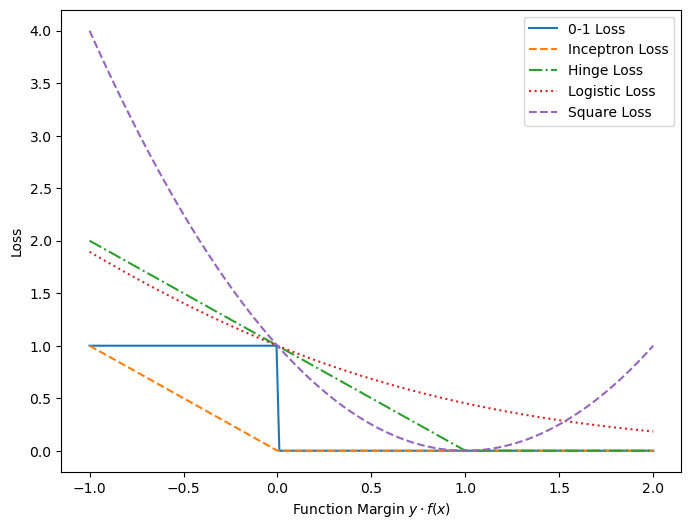

In [7]:
fig = plt.figure(figsize=(8,6))
linestyle = ["-", "--", "-.", ":", "--"]
for i,(name,l) in enumerate(loss.items()):
    plt.plot(yf,l,label=name,lw=1.5,ls=linestyle[i])
plt.legend()
plt.xlabel("Function Margin $y\cdot f(x)$")
plt.ylabel("Loss")

现在，我们将各种机器学习分类算法归纳到了统一的框架，能从不同算法的损失函数中感受算法的精神和思想，这有助于理解算法的行为，理解决策边界的形成

由于0-1损失不是连续可导的，直接优化尤其构成的目标函数比较困难，于是人们提出各种损失函数来“代替”它完成优化任务

在图中可以看到、合页损失、Logistic损失都是0-1损失的上界，这种上届损失函数被称为**代理损失函数**（**Surrogate Loss**）

感知机的损失函数当样本被正确分类时，损失为0，否则损失时 $-y(wx+b)$，相比之下，**合页损失函数不仅要分类正确，而且要确信度足够高**（大于1）时损失才是0，也就是说，合页损失函数对模型学习的要求更高

现在，你能理解为什么我们一般不用平方损失作为二分类问题的损失函数了吗？

另外一个简单补充的概念叫做**代理损失的相合性**，对于给定的代理损失函数 $\ell(y,f(x))$，令 $f^*(x) \in \mathbb{R}$ 表示理论上的最优决策函数：
$$
f^*(x) = \mathop{\arg\min}\limits_{f} \mathbb{E}\left[ \ell(Y,f(X))|X=x \right]
$$

我们再令 $y_{\text{bayes}}^*(x)$ 表示0-1损失下的最优分类器，即贝叶斯分类器（回忆0-1损失是贝叶斯分类器所使用的损失函数）

如果满足：$\text{sign}(f^*(x)) = y_{\text{bayes}}^*(x)$，则称 $\ell(y,f(x))$ 为**相合的**，事实上，我们有如下的相合性判断定理

**(Thm) 损失函数的相合性**：对于代理损失 $\ell(y,f(x)) : {-1,+1}\times \mathbb{R}\to\mathbb{R}$，令 $\ell(y,f(x)) = \phi(y\cdot f(x))$，如果：
* $\phi(t)$ 是凸函数
* $\phi(t)$ 可导且 $\phi^{'}(0) < 0$  
则 $\ell(y,f(x))$ 是相合的

可以验证，上面提到的0-1损失的上届损失函数都是**相合的**，那么请思考，相合的代理损失有什么意义呢？

### **2.3 非线性支持向量机**

当分类问题是非线性的，这时候就需要非线性SVM了，非线性SVM在线性SVM的基础上引入核技巧（Kernel），让SVM的分类能力大大提升

#### **2.3.1 核函数和核技巧**

首先，我们介绍**非线性分类问题**，非线性分类问题指的是只能用非线性模型才能很好地进行分类的问题，如下面的例子所示

Text(0, 0.5, '$X_2$')

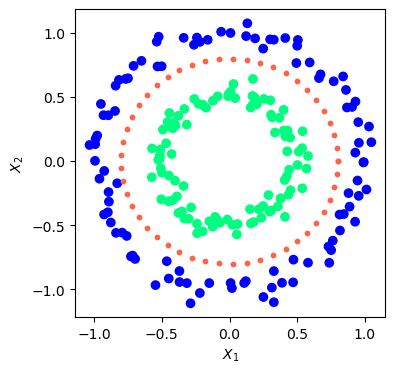

In [8]:
X, y = make_circles(n_samples=200,noise=0.05,factor=0.5,random_state=1234)
fig = plt.figure(figsize=(4,4))
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.winter)
# 绘制分隔椭圆，使用极坐标系生成
r = 0.8
theta = np.linspace(0,2*np.pi,50)
x1_circle = r*np.cos(theta)
x2_circle = r*np.sin(theta)
plt.scatter(x1_circle,x2_circle,color="tomato",s=10)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

图中两种颜色分别代表正例和负例样本，由图可见，**无法用直线（线性模型）将两类样本分隔开，但可以用一条椭圆曲线将它们分隔开**

类似地，如果能用 $\mathbb{R}^p$ 中的一个**超曲面**将正负类样本分开，则称这个问题为**非线性可分问题**

非线性问题往往不好求解，所以希望使用求解线性分类问题的方法解决该问题，所采取的方法是对数据做**非线性变换**，将**非线性问题转换为线性问题**

我们设原空间为 $X\subset \mathbb{R}^2$，新空间 $Z\subset \mathbb{R}^2$，原空间到新空间的映射关系为：
$$
z = \phi(x) = \left( (x^{(1)})^2, (x^{(2)})^2 \right)
$$

即将每个坐标元素进行平方运算，经过变换后，原空间的点被变换到新空间，如下图所示

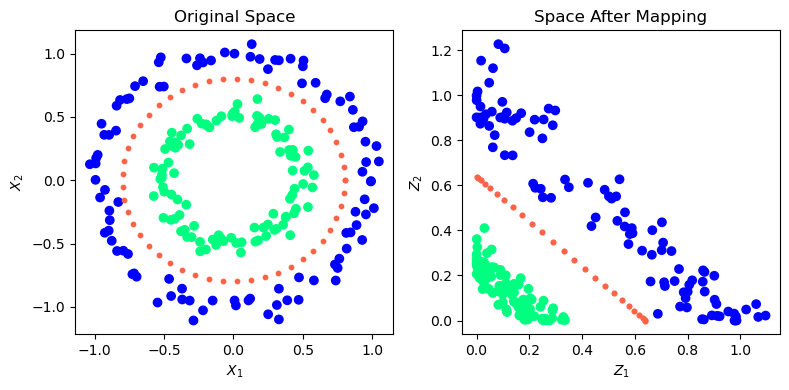

In [9]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax = ax.flatten()
ax[0].scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.winter)
ax[0].scatter(r*np.cos(theta),r*np.sin(theta),color="tomato",s=10)
ax[0].set_xlabel("$X_1$")
ax[0].set_ylabel("$X_2$")
ax[0].set_title("Original Space")
# 做变换
Z = X**2
z1_circle = x1_circle**2
z2_circle = x2_circle**2
ax[1].scatter(Z[:,0],Z[:,1],c=y,cmap=plt.cm.winter)
ax[1].scatter(z1_circle,z2_circle,color="tomato",s=10)
ax[1].set_xlabel("$Z_1$")
ax[1].set_ylabel("$Z_2$")
ax[1].set_title("Space After Mapping")
plt.tight_layout()

在这个变换中，原空间中的圆：
$$
(x^{(1)})^2 + (x^{(2)})^2 = 0.8^2
$$
在新空间中变为直线：
$$
z^{(1)} + z^{(2)} = 0.8^2
$$

并且可以看到，原问题中非线性可分的问题，在**新空间中变为了线性可分的**

上面的例子说明，想要用线性分类方法求解非线性问题，主要分为两步：
* 首先使用一个变换，将原输入空间 $X$ 映射到新的特征空间 $Z$
* 在新空间中，用线性SVM的方法从训练数据中学习模型

核技巧应用到SVM的基本思想就是使用一个非线性变换将输入空间 $X$（**欧氏空间**）对应于一个特征空间 $Z$（新的**欧式空间**或**Hilbert空间**），使得在输入空间 $X$ 中的**超曲面**对应于特征空间 $Z$ 中的**超平面**（**支持向量机**），这样，SVM学习过程就能够照搬到特征空间中

**(Def) 核函数**：设 $X$ 是输入空间（欧氏空间的子集或者离散集合），又设 $\mathcal{H}$ 为特征空间（Hilbert空间），如果存在一个从 $X$ 到 $\mathcal{H}$ 的映射：
$$
\phi(x) : X \to \mathcal{H}
$$
使得对所有的 $x,z\in X$，函数 $K(x,z)$ 满足条件：
$$
K(x,z) = \langle \phi(x),\phi(z)\rangle
$$
则称 $K(x,z)$ 为核函数，$\phi(x)$ 为映射函数

核技巧的想法是，在学习与预测的过程中，**只定义核函数** $K(x,z)$，而**不显式的寻找从输入空间到特征空间的映射** $\phi$，通常，直接计算 $K(x,z)$ 比较容易，但通过 $\phi(x),\phi(z)$ 来计算 $K(x,z)$ 并不容易，一般情况下，$\mathcal{H}$ 是高维的，甚至是无穷维的，我们应该避免去寻找 $\phi$

另一种避免直接使用 $\phi$ 的原因可以考虑下面的例子，假设原空间 $X = \mathbb{R}^p$，如果要为原空间添加非线性特征，我们考虑施加多项式映射

在 $p=2$ 时，如果多项式次数 $k=2$，那么需要添加特征 $(x^{(1)})^2,x^{(1)}x^{(2)},(x^{(2)})^2$，即包含交叉项的3个二次项，如果输入空间维度 $p=3$，那么二次项的个数将会增加到6个，维度为 $p$ 所需的二次项个数为：
$$
p + \binom{p}{2} = p + \frac{p(p-1)}{2} \sim \mathcal{O}(p^2)
$$
如果增加多项式的次数 $k$，那么需要添加包含低次项在内的，次数不超过 $k$ 次的所有项，数量会极大增加，这极大增加了计算难度，算法的效率也会大打折扣

**注意**：对于给定的核函数 $K(x,z)$，特征空间 $\mathcal{H}$ 和映射函数 $\phi$ 的取法并不唯一，可以找不同的特征空间，即便是同一空间也可以取不同的映射，参见习题

下面，我们回顾到线性SVM的对偶问题，目标函数为：

$$
W(a) = \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j\langle x_i, x_j\rangle - \sum_{i=1}^{N} a_i
$$

策略函数为：

$$
w^* = \sum_{i=1}^{N} a_i^*y_ix_i \\
b^* = y_j - \sum_{i=1}^{N}a_i^*y_i\langle x_i,x_j\rangle \\
f(x) = \text{sign}(w^*x + b^*) = \text{sign}\left( \sum_{i=1}^{N}a_i^*y_i \langle x_i, x\rangle + b^* \right)
$$

无论是目标函数，还是决策函数，都**只涉及实例与实例之间的内积**，核技巧将内积用核函数 $K(x_i,x_j) = \langle \phi(x_i),\phi(x_j)\rangle$ 代替，此时对偶问题目标函数为：

$$
W(a) = \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j K(x_i,x_j) - \sum_{i=1}^{N} a_i
$$

同样地，决策函数中的内积也用核函数替代，得到：

$$
f(x) = \text{sign}(w^*x + b^*) = \text{sign}\left( \sum_{i=1}^{N}a_i^*y_i K(x_i,x_j) + b^* \right)
$$

这样子，我们将原来的输入通过变换转换到新的特征空间，原空间中的内积 $\langle x_i,x_j\rangle$ 转换到特征空间中的内积 $\langle \phi(x_i),\phi(x_j)\rangle$，当映射函数是非线性函数时，学习得到的SVM是非线性分类器，因此，当给定核函数 $K(x_i,x_j)$ 时，就可以完全**按照线性SVM的方法求解非线性SVM**，学习是**隐式地在特征空间进行的**，而不需要在意具体的映射 $\phi$

我们叙述引入核技巧的SVM学习算法

**核技巧SVM的对偶算法**：给定数据集 $T=\{(x_i,y_i)\}_{i=1}^{N}$，其中 $x_i\in\mathcal{X}=\mathbb{R}^p$，$y_i\in\mathcal{Y}=\{-1,+1\}$，给定惩罚系数 $C > 0$ 和给定核函数 $K(x,z)$
* 第一步，构造并求解约束最优化问题，得到 $a^*$：
$$
\begin{array}{cl}
\min_{a} & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}a_ia_jy_iy_j K(x_i,x_j) - \sum_{i=1}^{N}a_i } \\
\text{s.t.} & \displaystyle{\sum_{i=1}^{N}a_iy_i = 0} \\
& 0\leq a_i\leq C,\quad i=1,2,\cdots,N
\end{array}
$$
* 第二步，选择一个 $a^*$ 的正分量 $0 < a_j^* < C$，计算分离超平面参数
$$
w^* = \sum_{i=1}^{N}a_i^*y_ix_i,\quad b^* = y_j - \sum_{i=1}^{N}a_i^*y_i K(x_i,x_j)
$$
* 第三步，得到分离超平面 $w^*x + b^* = 0$，SVM的决策函数为：
$$
f(x) = \text{sign}\left(\sum_{i=1}^{N}a_i^*y_i K(x,x_i) + b^*\right)
$$

在实际应用过程中，**核函数的选择需要依赖邻域知识或尝试决定**，下面我们介绍正定核函数的概念和常用的核函数

#### **2.3.2 正定核函数**

在给定 $\phi$，可以通过 $\phi(x),\phi(z)$ 来求得核函数 $K(x,z)$，但反过来，我们还没有说明，**给定任意一个函数** $K(x,z)$，**能否判断它是一个核函数？**，即 $K(x,z)$ 满足什么条件才能成为核函数？接下来我们说明，满足**正定核条件**的函数 $K(x,z)$ 即为所求

**(Def) 正定核**：如果对于对称函数 $K(x,z)$，存在映射 $\phi$ 使得 $K(x,z) = \langle \phi(x),\phi(z)\rangle$，则称 $K(x,z)$ 为正定核 

假设 $K(x,z)$ 是定义在 $X\times X$ 上的**对称函数**，并且对任意 $x_1,\cdots,x_m\in X$，$K(x,z)$ 关于 $x_1,\cdots,x_m$ 的Gram矩阵是半正定的，则可以根据函数 $K(x,z)$，构造一个Hilbert空间，具体步骤是：
* 首先定义映射 $\phi$ 并构成向量空间 $S$
* 在 $S$ 上定义内积构成内积空间
* 完备化 $S$ 使其成为Hilbert空间

**(1) 定义映射，构成向量空间 $S$**

首先定义 $\phi$：
$$
\phi : x\to K(*,x)
$$

这里需要一些抽象思维，像空间 $K(*,x)$ 是一个函数空间

根据这一映射，对任意 $x_i\in X,a_i\in\mathbb{R},i=1,\cdots,m$，定义线性组合：
$$
f(*) = \sum_{i=1}^{m} a_iK(*,x_i)
$$

考虑由所有线性组合为元素组成的集合 $S$，不难验证 $S$ 对加法和数乘封闭，因此 $S$ 是一个向量空间 

**(2) 在 $S$ 上定义内积，使其成为内积空间**

对任意 $f,g\in S$：
$$
f(*) = \sum_{i=1}^{m}a_i K(*,x_i),\quad g(*) = \sum_{j=1}^{l}b_j K(*,z_j)
$$

定义两个元素的内积：
$$
\langle f,g\rangle = \sum_{i=1}^{m}\sum_{j=1}^{l} a_ib_jK(x_i,z_j)
$$

接下来，需要证明以下性质，以此说明该运算构成内积：
* $\langle c\cdot f,g\rangle = c\cdot \langle f,g\rangle$
* $\langle f+g,h\rangle = \langle f,h\rangle + \langle g,h\rangle$
* $\langle f,g\rangle = \langle g.f\rangle$
* $\langle f,f\rangle \geq 0$
* $\langle f,f\rangle = 0 \Leftrightarrow f = 0$

前面三条性质直接计算验证即可，对于第四条，注意到：
$$
\langle f,f\rangle = \sum_{i,j=1}^{m} a_i a_j K(x_i,x_j)
$$

注意到Gram矩阵 $[K(x_i,x_j)]_{m\times m}$ 是半正定的，因此上式 $\langle f,f\rangle \geq 0$

对于第五条，充分性显然，为证明必要性，首先证明不等式：
$$
|\langle f,g\rangle|^2\leq \langle f,f\rangle \cdot \langle g,g\rangle
$$

设 $f,g\in S$，则 $f + \lambda g\in S$，注意有：
$$
\langle f+\lambda g,f+\lambda g\rangle \geq 0 \Rightarrow \langle f,f\rangle + 2\lambda \langle f,g\rangle + \lambda^2\langle g,g\rangle \geq 0
$$

上式关于 $\lambda$ 的二次对任意 $\lambda$ 都成立，因此根式判别小于等于0，即得所证：
$$
|\langle f,g\rangle|^2- \langle f,f\rangle \cdot \langle g,g\rangle \leq 0
$$

下面假设 $\langle f,f\rangle = 0$，证明 $f = 0$，注意到：
$$
f(*) = \sum_{i=1}^{m}a_i K(*,x_i)
$$

对任意 $x\in X$，考虑下面的内积：
$$
\langle K(*,x),f(*)\rangle = \sum_{i=1}^{m}a_i K(x,x_i) = f(x)
$$

上式表明 $|f(x)|^2 = |\langle K(*,x),f\rangle|^2$，将右式放缩，得到：
$$
|\langle K(*,x),f\rangle|^2 \leq \langle K(*,x),K(*,x)\rangle \cdot \langle f,f\rangle = K(x,x)\cdot \langle f,f\rangle = 0
$$

因此，当 $\langle f,f\rangle=0$ 时，对任意 $x$ 都成立 $f(x) = 0$，至此，说明了上述定义的二元运算符合内积定义，$S$ 在该运算下构成内积空间

**(3) 将内积空间 $S$ 完备化**

根据内积的定义，我们可以得到范数：
$$
\|f\| = \sqrt{\langle f,f\rangle}
$$

因此，$S$ 是赋范向量空间，根据泛函分析中的完备性定理，对于不完备的赋范向量空间 $S$，一定可以将其完备化，得到完备化的赋范向量空间 $\mathcal{H}$，这就得到了我们所需的Hilbert空间

这一Hilbert空间 $\mathcal{H}$ 称为**再生核Hilbert空间**，这是由于核函数 $K$ 具有**再生性**，称为**再生核**，即：
$$
\langle K(*,x),f\rangle = f(x) \quad\text{以及}\quad \langle K(*,x),K(*,z)\rangle = K(x,z)
$$

综合上述讨论，我们可以得到正定核定理

**(Thm) 正定核的充要条件**：设 $K:X\times X\to\mathbb{R}$ 是对称函数，则 $K(x,z)$ 为正定核函数的充要条件是对任意 $x_i\in X,i=1,\cdots,m$，$K(x,z)$ 的Gram矩阵 $K=[K(x_i,x_j)]_{m\times m}$ 是半正定矩阵

先证明必要性，假设 $K(x,z)$ 是正定核，则存在映射 $\phi$ 使得 $K(x,z) = \langle \phi(x),\phi(z)\rangle$，于是，对任意 $x_1,\cdots,x_m$，构造Gram矩阵：
$$
[K_{ij}]_{m\times m} = [K(x_i,x_j)]_{m\times m}
$$

对任意 $c_1,\cdots,c_m\in\mathbb{R}$，有：
$$
\begin{array}{rcl}
\sum_{i,j=1}^{m} c_ic_jK(x_i,x_j) & = & \displaystyle{ \sum_{i,j=1}^{m}c_ic_j\langle \phi(x_),\phi(x_j)\rangle } \\
& = & \displaystyle{ \langle \left(\sum_{i} c_i\phi(x_i) \right),\left(\sum_{i} c_i\phi(x_i) \right)\rangle } \\
& = & \displaystyle{ \|\sum_{i} c_i\phi(x_i)\|^2 \geq 0 }
\end{array}
$$

因此，$K(x,z)$ 关于 $x_1,\cdots,x_m$ 的Gram矩阵是半正定的

对于必要性，按照前文讨论的内容，定义映射 $\phi:x\to K(*,x)$，则：
$$
\langle \phi(x),\phi(z)\rangle = \langle K(*,x),K(*,z)\rangle = K(x,z) 
$$

上述定理是正定核的充要条件，因此，也可以作为正定核的另一个定义

**(Def) 正定核的等价定义**：如果对于对称函数 $K(x,z)$，对任意 $x_i,i=1,\cdots,m$，$K(x,z)$ 对应的Gram矩阵是半正定的，则称 $K(x,z)$ 为正定核 

上述讨论，能够帮助我们挑选或构造核函数 $K(x,z)$，但更多时候，我们一般从**经典的核函数中选择**即可

#### **2.3.3 常用核函数**

**(1) 多项式核函数**

多项式核函数：
$$
K(x,z) = (x^Tz+1)^p
$$

多项式核函数对应的SVM是一个 $p$ 次多项式分类器 

**(2) 高斯核函数**

高斯核函数：
$$
K(x,z) = \exp\left( -\frac{\|x-z\|^2}{2\sigma^2} \right)
$$

高斯核函数对应的SVM是**高斯径向基函数**（**RBF**）分类器，他将原始的输入空间映射到无穷维空间，这是最常用的核函数

这里出现了一个新的超参数 $\sigma$，它是属于核函数的超参数，为了理解它的作用，我们考虑使用高斯核函数的决策函数：
$$
f(x) = \text{sign}\left( \sum_{i=1}^{N}a_iy_i\exp\left(-\frac{\|x-x_i\|^2}{2\sigma^2}\right) + b\right)
$$

回忆线性SVM，支持向量是那些 $a_i>0$ 的实例，因此，只有 $a_i>0$ 的点才会参与决策，而具体的决策过程，是计算给定样本点 $x$ 与每个支持向量点 $x_i$ 的**相似性**：
$$
K(x,x_i) = \exp\left(-\frac{\|x-x_i\|^2}{2\sigma^2}\right) \in (0,1]
$$

不难发现以下事实：
* 对于靠近 $x_i$ 的实例 $x$，$\|x-x_i\|^2\to 0$，因此 $K(x,x_i)\to 1$
* 对于远离 $x_i$ 的实例 $x$，$\|x-x_i\|^2\to \infty$，因此 $K(x,x_i)\to 0$

我们以二维为例，固定 $x_i = (1,1)$，观察核函数 $K(x,x_i)$ 的取值变化情况

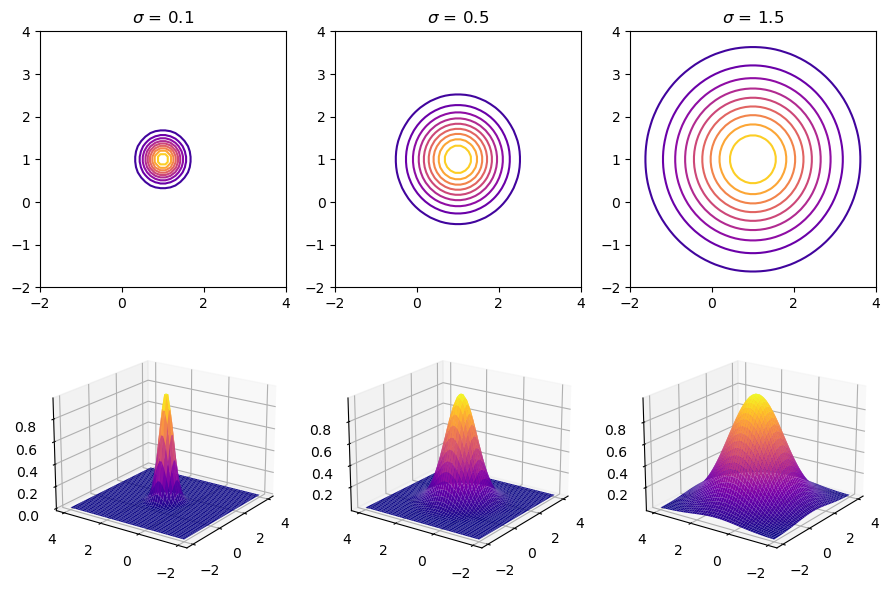

In [10]:
xi = np.array([1,1])
X1, X2 = np.linspace(-2,4,50), np.linspace(-2,4,50)
X1, X2 = np.meshgrid(X1,X2)
sigmas = [0.1, 0.5, 1.5]
# 绘图
fig = plt.figure(figsize=(9,6))
for i,sigma in enumerate(sigmas):
    # 计算核函数
    K = np.exp(-((X1 - xi[0])**2 + (X2 - xi[1])**2) / (2*sigma))
    ax = fig.add_subplot(2,3,i+1)
    ax.contour(X1,X2,K,levels=10,cmap=plt.cm.plasma)
    ax.set_title("$\sigma$ = %.1f"%(sigma))
    ax = fig.add_subplot(2,3,i+4,projection="3d")
    ax.view_init(azim=-145,elev=20)
    ax.plot_surface(X1,X2,K,cmap=plt.cm.plasma)
plt.tight_layout()

对图中可以看到，$\sigma$ **控制了每个支持向量的决策影响范围**：
* 对于较小的 $\sigma$，支持向量 $x_i$ 相似性 $K(x,x_i)$ 迅速衰减，远离 $x_i$ 的样本在决策时不受到该支持向量的影响
* 对于较大的 $\sigma$，支持向量 $x_i$ 相似性 $K(x,x_i)$ 衰减平缓，远离 $x_i$ 的样本在决策时依然会参与相关计算

对比**KNN**算法，这里的**超参数** $\sigma$ **的作用与KNN中的近邻个数** $k$ **的作用非常相似**，我们不难得到：
* $\sigma$ 偏小时，模型的决策偏向于考虑距离最近的几个支持向量，此时的模型是**低偏差、高方差**（容易**过拟合**）
* $\sigma$ 偏大时，模型的决策偏向于考虑到距离较远的更多的支持向量，此时的模型是**高偏差，低方差**（容易**欠拟合**）

以上事实阐明了在挑选超参数 $\sigma$ 时需要考虑的模型偏差和方差权衡，请记住，这些**控制模型复杂度的重要参数在使用任何模型时都需要谨慎**

### **2.4 关于SVM的补充说明**

#### **2.4.1 模型选择**

关于模型选择问题，我们做出一些简单说明

* 大部分场合下，使用**具有高斯核函数的SVM**能获得比较理想的效果
* 当特征维度 $p$ 很大（$\approx 10^2,10^3$），而样本量 $N$ 相对 $p$ 而言较小时（$\approx 10^2$），推荐使用**Logistic回归**或者**不带有核函数的线性SVM**
  * 使用L1正则化的Logistic回归非常适合此类**高维问题**
* 当特征维度 $p$ 正常（$p\in[1,200]$），样本量 $N$ 适中（约$N\in [1000,50000]$），推荐使用**具有高斯核函数的SVM**
* 当特征维度 $p$ 正常（$p\in[1,200]$），样本量 $N$ 很大（$N\approx 10^5,10^6$），SVM求解效率很慢，可使用**Logistic回归**或者**不带有核函数的线性SVM**

#### **2.4.2 支持向量回归SVR**

这里只介绍推广的最简单思想，详细的方法介绍可以参考1996年Drucker的论文[Linear Support Vector Regression Machines](https://www.researchgate.net/profile/Christopher-Burges/publication/221619762_Linear_Support_Vector_Regression_Machines/links/00b49518c11a5bab5d000000/Linear-Support-Vector-Regression-Machines.pdf)

在回归问题当中，我们的决策函数变为：
$$
f(x) = wx+b
$$

现在我们希望决策函数与标签 $y$ 的距离尽可能接近，**SVR的想法是使靠超平面最远的样本点之间的间隔最大**，它构造了如下的约束优化问题：

$$
\begin{array}{rl}
\min_{w,b} & \displaystyle{\frac{1}{2}\|w\|^2} \\
\text{s.t.} & |y_i - (wx_i+b)| \leq \epsilon,\quad i=1,\cdots,N
\end{array}
$$

$\epsilon$ 是算法的**容许误差边界**，就像**SVM中要求函数间隔定义的确信度** $y_i(wx_i+b)$ **需要大于等于1**一样

下图展示 $p=1$ （一维场景下）时SVR求解得到的结果，我们做出如下说明：
* 与SVM类似，SVR会得到一个图中**黄色区域的间隔**，我们称为 $\epsilon-$**管道**，管道宽度就是间隔（margin）宽度，等于 $2/\|w\|$
* **管道内的所有样本点，都满足约束** $|y_i - (wx_i+b)|\leq \epsilon$，即**红色箭头表示的范围**
* **管道的边界即为SVR的间隔边界**，分别是上界超平面 $H_1: y=wx+b+\epsilon$ 和下界超平面 $H_2:y=wx+b-\epsilon$
* **管道的中心就是SVR的回归超平面**，对应 $S:y=wx+b$
* 间隔边界上**蓝色点**是SVR的**支持向量**
* SVM中，不会有样本点在间隔边界内，而SVR，其他**非支持向量点，图中绿色点，全部落入到间隔边界内，即管道内部**

<img src="./source/Chap5/回归超平面.png" width=600>

SVR的目标是极小化 $0.5\cdot\|w\|^2$，在 $\epsilon$ 固定的情况下，SVR寻找**最平**的回归超平面，如下图所示

<img src="./source/Chap5/最平的回归超平面.png" width=1000>

如果三张图的样本都满足约束，那么模型会选择最右侧的求解结果，即此时回归超平面**最平**

从左到右，我们也能观察到，**随着超平面变平**，即 $\|w\|^2\to 0$，$\epsilon-$**管道宽度会逐渐变宽**，这就是**最大化间隔的含义**

接下来考虑为每个样本引入松弛变量、或者引入核技巧推广到非线性回归问题，SVR的操作思路与SVM几乎完全一致

#### **2.4.3 算法使用**

`sklearn`中提供了SVM和SVR的实现，非常便于使用

如果你不使用核函数，可以使用`LinearSVC`（分类器）和`LinearSVR`（回归器），如下所示

```python
from sklearn.svm import LinearSVC, LinearSVR
model = LinearSVC() # 创建模型
model.fit(X_train,y_train) # 训练模型
y_pred = model.predict(X_test) # 进行预测
```

如果需要使用核函数，就使用`SVC`（分类器）和`SVR`（回归器）

```python
from sklearn.svm import SVC, SVR
model = SVC(kernel="rbf") # 创建模型，设置核函数
model.fit(X_train,y_train) # 训练模型
y_pred = model.predict(X_test) # 进行预测
```

此外，在处理分类问题时：
* 虽然算法说明中，我们规定标签 $y$ 取值自 $\{-1,+1\}$，但在**使用这些算法包时，不需要我们手动完成该转换，算法包内部会自动完成**
* `SVC()`和`LinearSVC()`均支持**多分类问题**，可以直接使用它们进行多分类问题的建模和预测

---

### **练习**

1. (**编程训练**) 定义一个函数`PerceptronDual()`实现**感知机**求解的对偶算法，函数接口说明如下：

In [11]:
def PerceptronSGD(X : np.ndarray, y : np.ndarray, eta : float=1):
    """
    Parameters
    ----------
    X : np.ndarray
        训练集的输入特征
    y : np.ndarray
        训练集标签，取值`{-1,+1}`
    eta : float, default = `0.5`
        学习率
    
    Return
    ----------
    (w,b) : np.ndarray
        返回分离超平面的参数
    """
    
    # 在下面编写你的代码
    ...

2. 如果用感知机求解一个**非线性可分**的问题，算法求解会遇到什么问题？算法会收敛吗？借用**线性SVM**处理**近似线性可分问题**的思路，你能改进感知机算法，使其也能处理近似线性可分问题吗？

3. 比较感知机和SVM的对偶算法，寻找异同，加深理解

4. 有时候，线性SVM的优化问题还被定义为如下形式：
$$
\begin{array}{rl}
\min_{w,b,\xi} & \displaystyle{\frac{1}{2}\|w\|^2 + C\sum_{i=1}^{N}\xi_i^2  } \\
\text{s.t.} & y_i(wx_i+b)\geq 1- \xi_i,\quad i=1,\cdots,N \\
& \xi_i\geq 0,\quad i=1,\cdots,N
\end{array}
$$
与正文中介绍的线性SVM的区别在于，对于松弛变量的惩罚项变为了平方惩罚：
$$
C\sum_{i=1}^{N}\xi_i \Rightarrow C\sum_{i=1}^{N}\xi_i^2
$$
完成下面两个问题：
* 尝试给出新设定下原问题的对偶形式，并给最优解需要满足的所有KKT条件
* 根据你学过的所有知识，你会联想到什么？对比这两种设定在求解结果上可能有什么异同

5. 这个问题中，我们展示核函数与映射的关系，考虑输入空间是 $\mathbb{R}^2$，核函数是 $K(x,z)=(x^Tz)^2$，考虑两个空间和映射：
* $\mathcal{H}=\mathbb{R}^3$，$\phi(x) = \left( (x^{(1)})^2,\sqrt{2}x^{(1)}x^{(2)}, (x^{(2)})^2 \right)$
* $\mathcal{H}=\mathbb{R}^4$，$\phi(x) = \left( (x^{(1)})^2,x^{(1)}x^{(2)},x^{(1)}x^{(2)}, (x^{(2)})^2 \right)$  
其中，上标表示分量，对以上两个设定，验证 $\langle \phi(x),\phi(z)\rangle = K(x,z)$，由次说明，对同一个核函数 $K(x,z)$，可以找到不同的像空间 $\mathcal{H}$ 和映射 $\phi$ 与之对应

6. 运行下面的代码，生成数据集，然后完成下面的任务

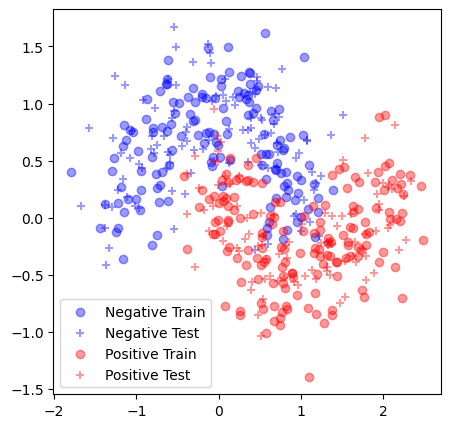

In [12]:
# 生成数据
X,y = make_moons(n_samples=500,noise=0.3,random_state=1234)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=0)
# 绘图
fig = plt.figure(figsize=(5,5))
for i in [0,1]:
    label = "Positive" if i == 1 else "Negative"
    color = "red" if i == 1 else "blue"
    plt.scatter(X_train[y_train==i,0],X_train[y_train==i,1],
                marker="o",color=color,label="%s Train"%(label),alpha=0.4)
    plt.scatter(X_test[y_test==i,0],X_test[y_test==i,1],
                marker="+",color=color,label="%s Test"%(label),alpha=0.4)
plt.legend()

* 请使用高斯核函数SVM，**仅在训练集上**找到最优的惩罚系数 $C$ 和核函数尺度参数 $\sigma$，然后用最优参数训练模型，评估其在训练集和测试集上的表现
* 为算法设置一些极端的参数 $C,\sigma$，评估模型在训练集和测试集上的表现，并判断这属于**过拟合**还是**欠拟合**，加深对这两个参数的理解

----